# Problem2: Optimal Bayesian Estimation

# 0- First Some Data Pre-Processing

- At this moment you should have "train_PCA.pkl" and "test_PCA.pkl" files in your working directory

In [43]:
%matplotlib inline

import matplotlib
import pickle
import numpy as np
import math
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#np.set_printoptions(threshold=10)

train_data=pickle.load(open("train_PCA.pkl", "rb" ), encoding ='latin1')
test_data=pickle.load(open("test_PCA.pkl", "rb" ), encoding ='latin1')


In [44]:
def plot__roc_all_groups(t, p):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    test_vectorized = label_binarize(t, classes=[0,1,2,3])
    y =  label_binarize(p, classes=[0,1,2,3])

    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(test_vectorized[:,i],y[:,i]) # i column # pos_label=i
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    lw = 2
    for i in range(4):
        plt.figure()
        plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example_group'+str(i))
        plt.legend(loc="lower right")
        filename="ROC_"+str(i)+".png"
        plt.savefig(filename)

def plot_scatter_all_groups(predicted):
    temp_mat_0 = np.take(train_feature, np.where(predicted == 0)[0], axis=0)
    temp_mat_1 = np.take(train_feature, np.where(predicted == 1)[0], axis=0)
    temp_mat_2 = np.take(train_feature, np.where(predicted == 2)[0], axis=0)
    temp_mat_3 = np.take(train_feature, np.where(predicted == 3)[0], axis=0)
    
    pca = PCA(n_components=2)
    temp_mat_0_pca = pca.fit(temp_mat_0).transform(data_mat_0).transpose()
    plt.scatter(temp_mat_0_pca[0], temp_mat_0_pca[1], label="0")
    temp_mat_1_pca = pca.fit(temp_mat_1).transform(data_mat_1).transpose()
    plt.scatter(temp_mat_1_pca[0], temp_mat_1_pca[1], label="1")
    temp_mat_2_pca = pca.fit(temp_mat_2).transform(data_mat_2).transpose()
    plt.scatter(temp_mat_2_pca[0], temp_mat_2_pca[1], label="2")
    temp_mat_3_pca = pca.fit(temp_mat_3).transform(data_mat_3).transpose()
    plt.scatter(temp_mat_3_pca[0], temp_mat_3_pca[1], label="3")
    plt.title('Decision Boundary for this formulation of Covariance')


In [45]:
categories = ['alt.atheism',
              'talk.religion.misc',
              'comp.graphics',
              'sci.space']

num_classes = len(categories)

In [46]:
val_ratio  = 0.1 
e=math.e
L = [e**-25, e**-20, e**-15, e**-10, e**-5,0,1,2,3, e**5, e**10] # range of lambda

In [47]:
#Split Train data into Train and Validation (Ratio Train : Val = 4:1)

train_num = int(train_data['data'].shape[0]*(1.0-val_ratio)) 
val_num = -1*int(train_data['data'].shape[0]*val_ratio)

In [48]:
#Train data and Train Target
#Validation data and Validation Target

train_feature = train_data['data'][:train_num]
train_target = train_data['target'][:train_num]

val_feature = train_data['data'][val_num:]
val_target = train_data['target'][val_num:]

test_feature = test_data['data']
test_target = test_data['target']
test_num = test_data['data'].shape[0] 

In [49]:
# shape of data set

print(train_feature.shape)
print(val_feature.shape)
print(test_num)

(1830, 1500)
(203, 1500)
1353


# 1- Find Mean and Prior for Estimating Multivariate Normal Dist. for Classes

In [50]:
# Find the mean and prior (which is just the frequency)
mu = np.zeros((len(categories), train_feature.shape[1]), dtype=float)
Pi = np.zeros(len(categories),dtype=float)

num_features = train_feature.shape[1]

unique, Pi = np.unique(train_target, return_counts=True)

data_mat_0 = np.take(train_feature, np.where(train_target == 0)[0], axis=0)
data_mat_1 = np.take(train_feature, np.where(train_target == 1)[0], axis=0)
data_mat_2 = np.take(train_feature, np.where(train_target == 2)[0], axis=0)
data_mat_3 = np.take(train_feature, np.where(train_target == 3)[0], axis=0)

np.mean(data_mat_0, axis=0, out=mu[0])
np.mean(data_mat_1, axis=0, out=mu[1])
np.mean(data_mat_2, axis=0, out=mu[2])
np.mean(data_mat_3, axis=0, out=mu[3])

Pi = np.log(Pi/train_num)

# 2- Build Models For Several Cases

For each case consider the followings:


- First, compute the covariance matrix (name it cov)

- Build the Multivariate Normal dist. based on the computed mean and cov.

- Then build the Model

- Report the Confusion Matrix, ROC and plot the data scatter and the decision boundaries in 2D (so based on top-2 PCA features). For the Confusion matrix and ROC, use Scilearn built in functions.

 *Case 0: multivariate normals with shared spherical variances:*
 
- In this case, the cov is taken to be a diagonal matrix with the same element on diag which is the average of the feasure variances, i.e. sum(diag(cov(x)))/2*eye(2), x is the data point matrix.

[[219  26   6  68]
 [  1 377   8   3]
 [  1  28 363   2]
 [ 28  21   7 195]]
0.852919438285


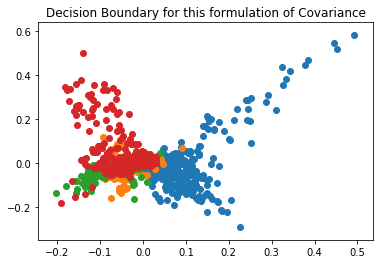

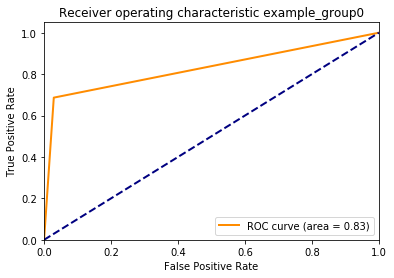

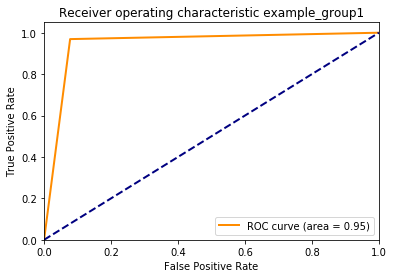

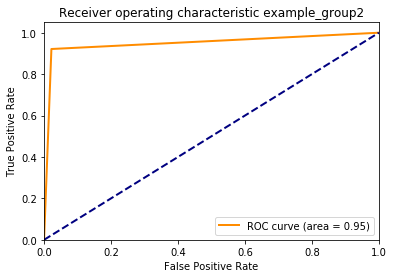

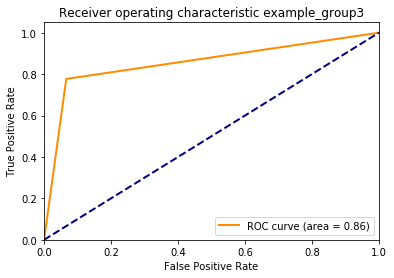

In [51]:
#In this case, we  keep the average variance along the diagonal of the covariance matrix of the entire data.
#This results in very gaussians withd ifferent means but same variances. The constant probability curve
#for each class are axis-parallel hyperspheres.

cov_0 = (np.sum(np.diag(np.cov(train_feature, rowvar=False)))/num_features) * np.eye(num_features)

p_xy = np.zeros((4, test_num), dtype=float)

p_xy[0] = multivariate_normal(mean=mu[0], cov=cov_0).logpdf(test_feature) + Pi[0]
p_xy[1] = multivariate_normal(mean=mu[1], cov=cov_0).logpdf(test_feature) + Pi[1]
p_xy[2] = multivariate_normal(mean=mu[2], cov=cov_0).logpdf(test_feature) + Pi[2]
p_xy[3] = multivariate_normal(mean=mu[3], cov=cov_0).logpdf(test_feature) + Pi[3]

temp = np.sum(p_xy, axis=0)

prediction_case_0 = p_xy.argmax(axis=0)

conf_mat_case_0 = confusion_matrix(test_target, prediction_case_0)

test_accuracy_case_0 = accuracy_score(test_target, prediction_case_0)
print(conf_mat_case_0)
print(test_accuracy_case_0)

plot_scatter_all_groups(prediction_case_0)
plot__roc_all_groups(test_target, prediction_case_0)

*Case 1: multivariate normals with shared axis parellel variances:*

- In this case, first the cov is taken to be the diagonal matrix with the variance of each feasure on the diag, i.e. diag(diag(cov(x))).

Confusion Matrix :
 [[255  12  15  37]
 [  0 382   6   1]
 [  1  25 368   0]
 [ 33  23  17 178]]
Test Accuracy :  0.874353288987


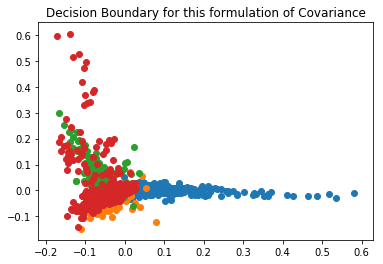

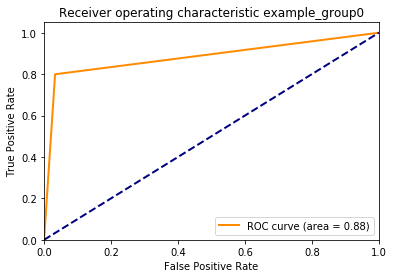

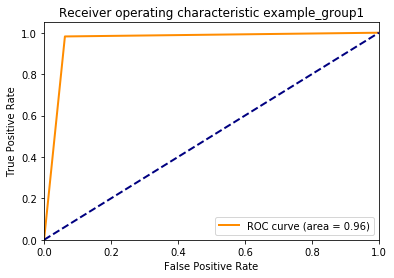

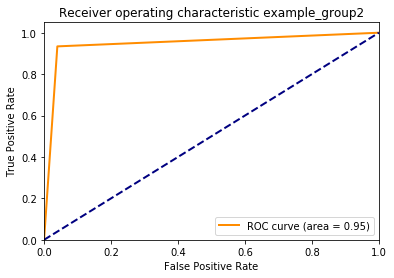

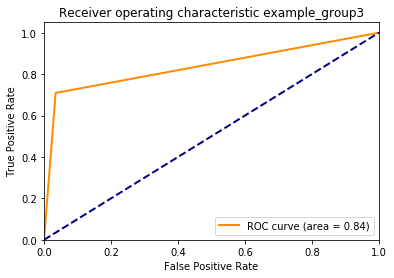

In [52]:
#In this case, we only keep the diagonal elements of the covariance matrix. This results in gaussians with
#different means but shared variance and constant probability regions are axis parallel hyperellipses


cov_0 = np.diag(np.diag(np.cov(train_feature, rowvar=False)))

p_xy[0] = multivariate_normal(mean=mu[0], cov=cov_0).logpdf(test_feature) + Pi[0]
p_xy[1] = multivariate_normal(mean=mu[1], cov=cov_0).logpdf(test_feature) + Pi[1]
p_xy[2] = multivariate_normal(mean=mu[2], cov=cov_0).logpdf(test_feature) + Pi[2]
p_xy[3] = multivariate_normal(mean=mu[3], cov=cov_0).logpdf(test_feature) + Pi[3]

prediction_case_1 = p_xy.argmax(axis=0)

conf_mat_case_1 = confusion_matrix(test_target, prediction_case_1)

test_accuracy_case_1 = accuracy_score(test_target, prediction_case_1)
print("Confusion Matrix :\n", conf_mat_case_1)
print("Test Accuracy : ", test_accuracy_case_1)

plot_scatter_all_groups(prediction_case_1)
plot__roc_all_groups(test_target, prediction_case_1)

*Case 2: multivariate normals with shared arbitrary variances:*

- In this case, first cov is taken to be the general covariance matrix of feasutes, i.e. cov(x).

Confusion Matrix :
 [[254  17  10  38]
 [  1 378   9   1]
 [  4  25 365   0]
 [ 32  20  13 186]]
Test Accuracy :  0.874353288987


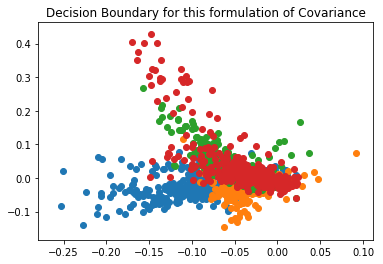

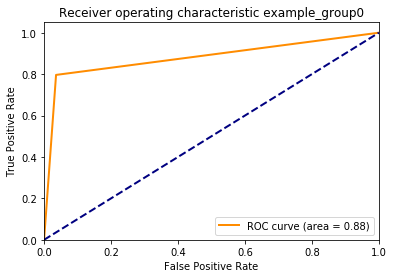

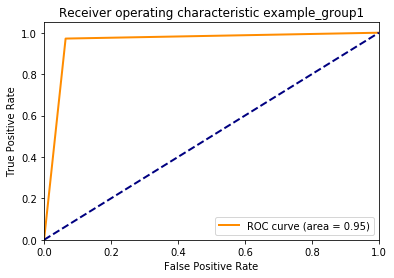

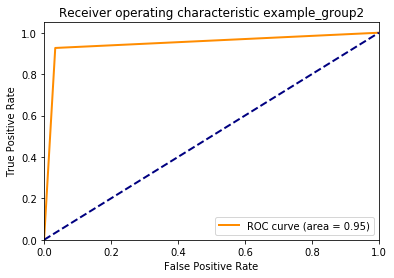

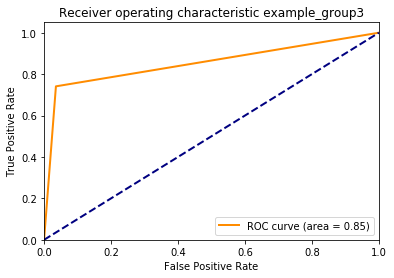

In [53]:
#In this case, we  keep the entire covariance matrix. This results in very general gaussians with
#different means and shared variance where constant probability regions are non-axis-parallel hyperellipses


cov_0 = np.cov(train_feature, rowvar=False)

p_xy[0] = multivariate_normal(mean=mu[0], cov=cov_0).logpdf(test_feature) + Pi[0]
p_xy[1] = multivariate_normal(mean=mu[1], cov=cov_0).logpdf(test_feature) + Pi[1]
p_xy[2] = multivariate_normal(mean=mu[2], cov=cov_0).logpdf(test_feature) + Pi[2]
p_xy[3] = multivariate_normal(mean=mu[3], cov=cov_0).logpdf(test_feature) + Pi[3]

prediction_case_2 = p_xy.argmax(axis=0)

conf_mat_case_2 = confusion_matrix(test_target, prediction_case_2)

test_accuracy_case_2 = accuracy_score(test_target, prediction_case_2)
print("Confusion Matrix :\n", conf_mat_case_2)
print("Test Accuracy : ", test_accuracy_case_2)

plot_scatter_all_groups(prediction_case_2)
plot__roc_all_groups(test_target, prediction_case_2)

*Case 3: multivariate normals with shared spherical variances:*

- In this case, first a cov is computed for each class.

Confusion Matrix :
 [[289   0  15  15]
 [ 16 268 104   1]
 [  4   2 388   0]
 [ 84   0  27 140]]
Test Accuracy :  0.80192165558


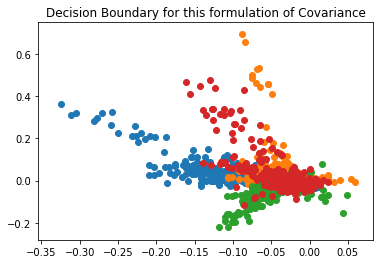

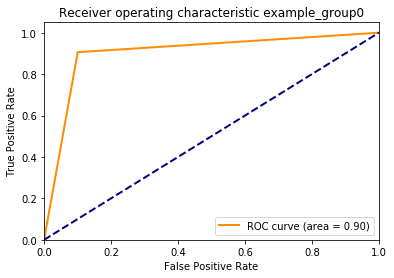

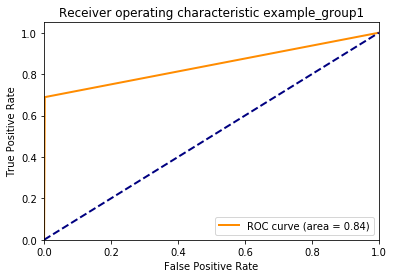

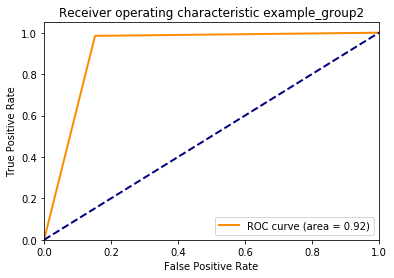

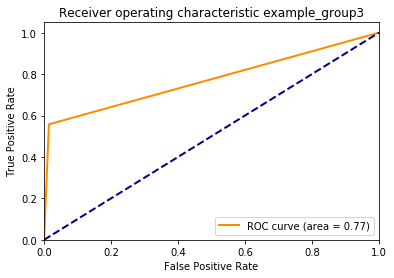

In [54]:
#In this case, we  keep the entire covariance matrix. This results in very general gaussians with
#different means and different variances. The constant probability curve  for each class are axis-parallel
#hyperspheres


cov_0 = (np.sum(np.diag(np.cov(data_mat_0, rowvar=False)))/num_features) * np.eye(num_features)
cov_1 = (np.sum(np.diag(np.cov(data_mat_1, rowvar=False)))/num_features) * np.eye(num_features)
cov_2 = (np.sum(np.diag(np.cov(data_mat_2, rowvar=False)))/num_features) * np.eye(num_features)
cov_3 = (np.sum(np.diag(np.cov(data_mat_3, rowvar=False)))/num_features) * np.eye(num_features)

p_xy[0] = multivariate_normal(mean=mu[0], cov=cov_0).logpdf(test_feature) + Pi[0]
p_xy[1] = multivariate_normal(mean=mu[1], cov=cov_1).logpdf(test_feature) + Pi[1]
p_xy[2] = multivariate_normal(mean=mu[2], cov=cov_2).logpdf(test_feature) + Pi[2]
p_xy[3] = multivariate_normal(mean=mu[3], cov=cov_3).logpdf(test_feature) + Pi[3]

prediction_case_3 = p_xy.argmax(axis=0)

conf_mat_case_3 = confusion_matrix(test_target, prediction_case_3)

test_accuracy_case_3 = accuracy_score(test_target, prediction_case_3)
print("Confusion Matrix :\n", conf_mat_case_3)
print("Test Accuracy : ", test_accuracy_case_3)

plot_scatter_all_groups(prediction_case_3)
plot__roc_all_groups(test_target, prediction_case_3)

Case 4: Same as case 3, but with reject option. Threshold 0.3

Confusion Matrix :
 [[289   0  15  15]
 [ 16 268 104   1]
 [  4   2 388   0]
 [ 84   0  27 140]]
Test Accuracy :  0.80192165558


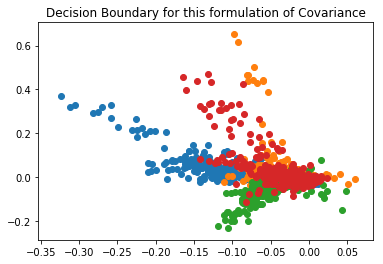

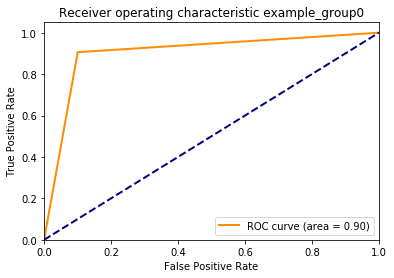

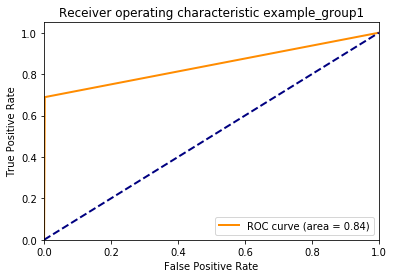

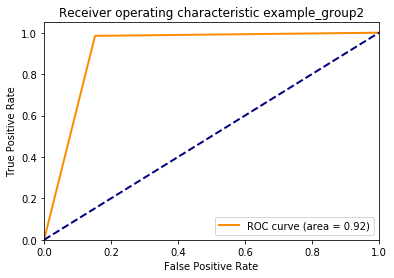

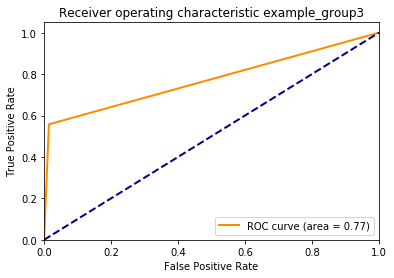

In [55]:
#In this case, we  keep the entire covariance matrix. This results in very general gaussians with
#different means and different variances. The constant probability curve for each class are axis-parallel
#hyperspheres. I have taken the reject-threshold to be 0.1.


from sklearn import metrics

reject_threshold = 0.1

def reject_outlier(a):
    return np.argmax(a) if np.max(a) > reject_threshold else 4

cov_0 = (np.sum(np.diag(np.cov(data_mat_0, rowvar=False)))/num_features) * np.eye(num_features)
cov_1 = (np.sum(np.diag(np.cov(data_mat_1, rowvar=False)))/num_features) * np.eye(num_features)
cov_2 = (np.sum(np.diag(np.cov(data_mat_2, rowvar=False)))/num_features) * np.eye(num_features)
cov_3 = (np.sum(np.diag(np.cov(data_mat_3, rowvar=False)))/num_features) * np.eye(num_features)

p_xy[0] = multivariate_normal(mean=mu[0], cov=cov_0).logpdf(test_feature) + Pi[0]
p_xy[1] = multivariate_normal(mean=mu[1], cov=cov_1).logpdf(test_feature) + Pi[1]
p_xy[2] = multivariate_normal(mean=mu[2], cov=cov_2).logpdf(test_feature) + Pi[2]
p_xy[3] = multivariate_normal(mean=mu[3], cov=cov_3).logpdf(test_feature) + Pi[3]

p_xy = p_xy / np.sum(p_xy, axis=0)

prediction_case_4 = np.apply_along_axis(reject_outlier, 0, p_xy)

conf_mat_case_4 = confusion_matrix(test_target, prediction_case_4)

test_accuracy_case_4 = accuracy_score(test_target, prediction_case_4)
print("Confusion Matrix :\n", conf_mat_case_4)
print("Test Accuracy : ", test_accuracy_case_4)

plot_scatter_all_groups(prediction_case_4)
plot__roc_all_groups(test_target, prediction_case_4)